In [2]:
import pandas as pd
import numpy as np
import matplotlib

In [3]:
# Loading mapping files
mapping_to_token = pd.read_csv("../csv_files/RxJava_csv/mapping_token.csv")
mapping_to_ast = pd.read_csv("../csv_files/RxJava_csv/mapping_ast.csv")
mapping_to_rel_ast = pd.read_csv("../csv_files/RxJava_csv/mapping_relative_ast.csv")
mapping_to_comp_sort_ast = pd.read_csv("../csv_files/RxJava_csv/mapping_sorted_comp_ast.csv")

mapping = {"token" : mapping_to_token, "ast" : mapping_to_ast, "relative_ast" : mapping_to_rel_ast, "comp_sorted_ast" : mapping_to_comp_sort_ast}

d_type = {"commit_hash" : "str", 	"num_additions" : int,	"num_deletions": int, "filename" : "str"}

# Function for loading data
def load_data(file):
    df = pd.read_csv(file)
    df = df[df.filename.str.endswith(".java")]
    return pd.DataFrame({"commit_hash": df.commit_hash, "changes": pd.to_numeric(df.num_additions) + pd.to_numeric(df.num_deletions)})

# Loading data
data_java = load_data("../csv_files/RxJava_csv/output_java.csv")
data_java_nws = load_data("../csv_files/RxJava_csv/output_nws.csv") 
data_token = load_data("../csv_files/RxJava_csv/output_token.csv")
data_ast = load_data("../csv_files/RxJava_csv/output_ast.csv")
data_comp_sort_ast = load_data("../csv_files/RxJava_csv/output_sort_comp_ast.csv")
data_rel_ast = load_data("../csv_files/RxJava_csv/output_relative_ast.csv")

data = {"java" : data_java, "java_nws" : data_java_nws, "token" : data_token, "ast" : data_ast, "comp_sort_ast" : data_comp_sort_ast,"relative_ast" : data_rel_ast}

In [4]:
# Setting up dataframes
df_java = data_java.groupby('commit_hash').sum()
df_java_nws = data_java_nws.groupby('commit_hash').sum()
df_token = pd.merge(data_token, mapping_to_token, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_token"}).drop(columns=["to", "commit_hash_token"]).groupby('commit_hash').sum()
df_ast = pd.merge(data_ast, mapping_to_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_ast"}).drop(columns=["to", "commit_hash_ast"]).groupby('commit_hash').sum()
df_sort_comp_ast = pd.merge(data_comp_sort_ast, mapping_to_comp_sort_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_comp_ast"}).drop(columns=["to", "commit_hash_comp_ast"]).groupby('commit_hash').sum()
df_rel_ast = pd.merge(data_rel_ast, mapping_to_rel_ast, left_on="commit_hash", right_on="to", validate="m:1", how="left").rename(columns = {"from": "commit_hash", "commit_hash": "commit_hash_rel_ast"}).drop(columns=["to", "commit_hash_rel_ast"]).groupby('commit_hash').sum()

dfs = {"java" : df_java, "java_nws" : df_java_nws, "token" : df_token, "ast" : df_ast, "sort_comp_ast" : df_sort_comp_ast, "relative_ast" : df_rel_ast}

In [5]:
def mergeall(**dfs):
    items = dfs.items()
    table = df_java.rename(columns = dict(changes="repo"))
    for key, df in items:
        table = pd.merge(table, df.rename(columns = dict(changes=key)), left_index=True, right_index=True, validate="1:1", how="outer")
    return table

df_merged = mergeall(nws = df_java_nws, token = df_token, ast = df_ast, sorted_comp_ast = df_sort_comp_ast, relative_ast = df_rel_ast).fillna(0, downcast="int64")

df_merged.isna().sum()
df_merged

,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
0000b2ceeacfe848e36e5316291e3936ef692349,68,62,286,2845,186,501
000a174d87a901135f9665d3b11f3627fd2dc4ed,40375,36691,145454,786067,98085,269557
001b696c35c928dd6bf26056ae6cd028220be100,375,375,1557,10553,814,2281
00459308557548fbd05f386048515d255ac53781,26,26,82,349,83,139
005f1553f3089c9c81ff00087e7708185084aa7a,149,149,170,1681,758,193
...,...,...,...,...,...,...
ffbfb6713df6c9c2731038963c01590e182f026f,24,24,24,24,168,24
ffe0fa1c7e6f38a668d1650c1409a9eb81604788,366,352,1605,15601,572,2481
ffe49c3f0e7a197daec8166dadde51c13fa9d3be,263,263,1162,20229,365,1891


<Axes: >

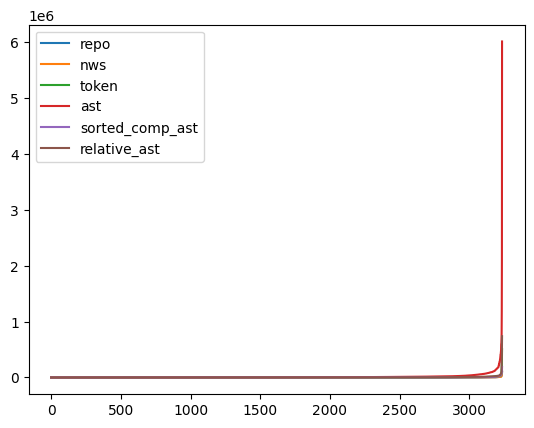

In [6]:
df = pd.DataFrame({k : np.array(df_merged[k].sort_values()) for k in df_merged.columns})
df.plot()

<Axes: >

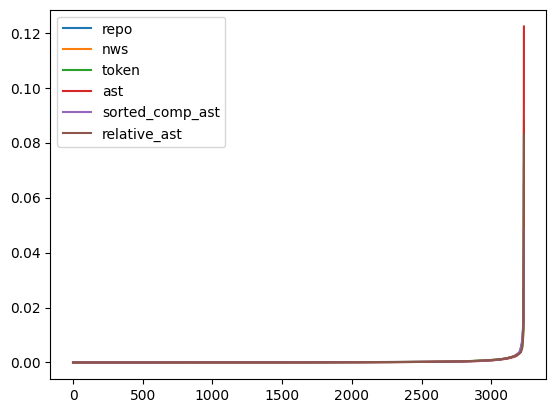

In [7]:
(df / df.sum()).plot()

In [28]:
all_integers = df.applymap(lambda x: isinstance(x, int)).all()

print(all_integers)

repo               True
nws                True
token              True
ast                True
sorted_comp_ast    True
relative_ast       True
dtype: bool


<Axes: >

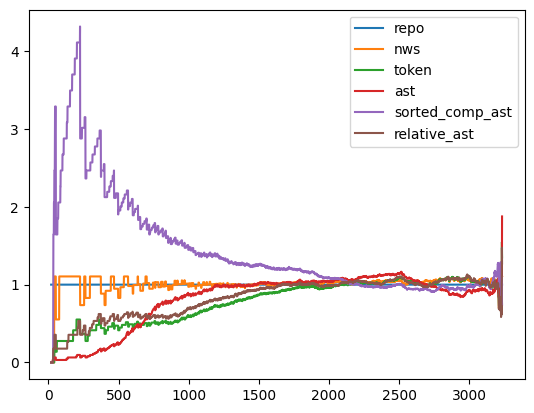

In [9]:
m = df.sum()
dt = df/m
dt.div(dt.repo, axis=0).plot()

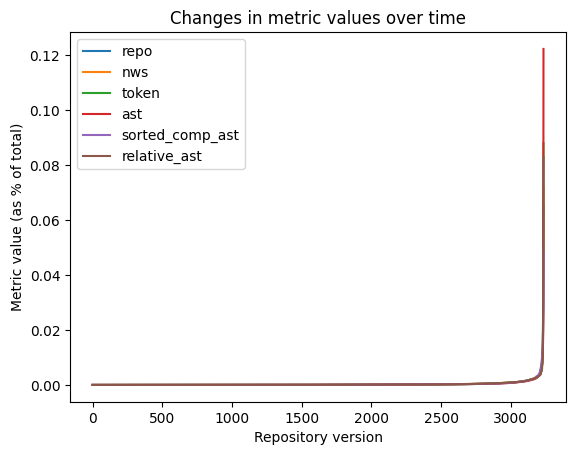

In [10]:
import matplotlib.pyplot as plt

(df[['repo','nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='line')
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Changes in metric values over time')
plt.show()


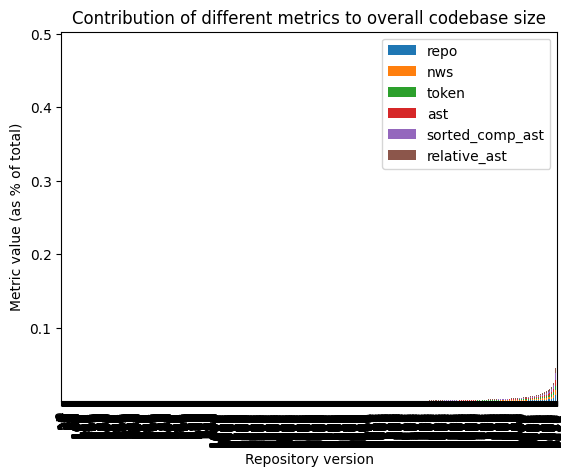

In [13]:
import matplotlib.pyplot as plt

(df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='bar', stacked=True)
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Contribution of different metrics to overall codebase size')
plt.show()


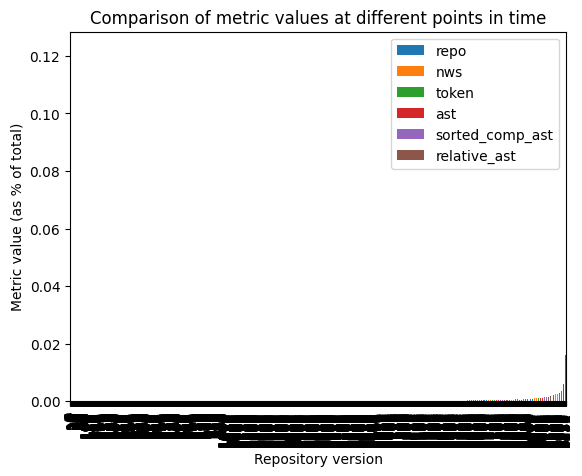

In [14]:
import matplotlib.pyplot as plt

(df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']] / df[['repo', 'nws', 'token', 'ast', 'sorted_comp_ast', 'relative_ast']].sum()).plot(kind='bar')
plt.xlabel('Repository version')
plt.ylabel('Metric value (as % of total)')
plt.title('Comparison of metric values at different points in time')
plt.show()


<Axes: >

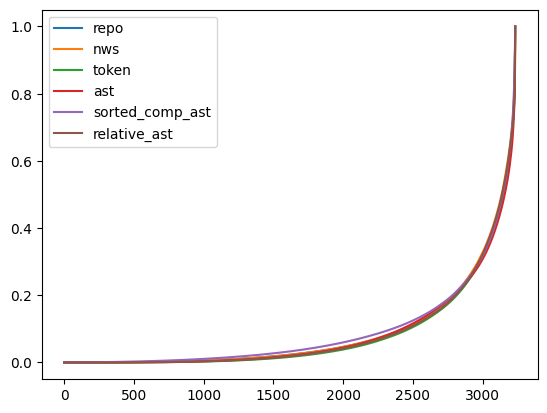

In [15]:
(df.cumsum() / df.sum()).plot()

<Axes: >

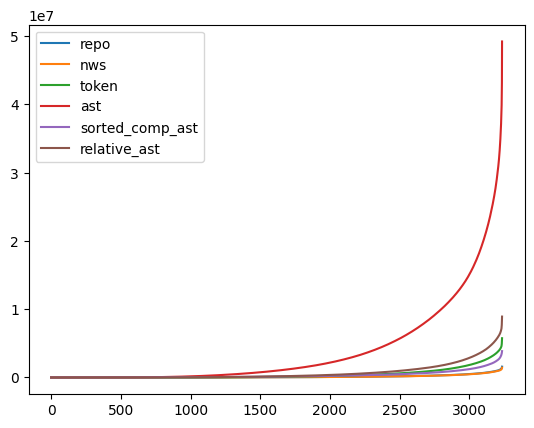

In [16]:
df.cumsum().plot()

In [19]:
#find størrelsen af filen for at finde en relativ ændring 
df_merged[df_merged.repo != 0][df_merged.nws == 0]

C:\Users\boran\AppData\Local\Temp\ipykernel_22460\3226036014.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_merged[df_merged.repo != 0][df_merged.nws == 0]


,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
0b6b4650105aa148ec3f69740c09a53b2631888f,2,0,2,2,30,2
0e2e73f6310c052920c1de24f415f9422af7cb30,136,0,0,32,38,32
105d20fdbc66493d98a25e2e5380df5a1e787437,428,0,0,82,142,82
18fbf8712e4530014371be51e14a8e839c80244b,2,0,0,0,0,0
1ea2cb97c42d8b27cb9ebef89f678c6c4bf47674,624,0,0,160,184,160
35281d57811dc5fad372b599db57129d40db05f7,44844,0,9608,9608,70810,9608
394fb92a0b41be1d6d98a19c2588987f0d3d3af1,10,0,0,0,0,0
414dbc410c0a7fc3bee81dc5f782a6433af82593,2,0,0,0,0,0
4d05c9cd1688f129930666e0b2c134da80bd7743,678,0,0,56,126,56


In [18]:
df_merged / df_merged.sum()

,repo,nws,token,ast,sorted_comp_ast,relative_ast
commit_hash,,,,,,
0000b2ceeacfe848e36e5316291e3936ef692349,0.000043,0.000043,0.000050,5.783067e-05,0.000048,0.000056
000a174d87a901135f9665d3b11f3627fd2dc4ed,0.025460,0.025573,0.025309,1.597848e-02,0.025428,0.030232
001b696c35c928dd6bf26056ae6cd028220be100,0.000236,0.000261,0.000271,2.145122e-04,0.000211,0.000256
00459308557548fbd05f386048515d255ac53781,0.000016,0.000018,0.000014,7.094167e-06,0.000022,0.000016
005f1553f3089c9c81ff00087e7708185084aa7a,0.000094,0.000104,0.000030,3.416990e-05,0.000197,0.000022
...,...,...,...,...,...,...
ffbfb6713df6c9c2731038963c01590e182f026f,0.000015,0.000017,0.000004,4.878510e-07,0.000044,0.000003
ffe0fa1c7e6f38a668d1650c1409a9eb81604788,0.000231,0.000245,0.000279,3.171235e-04,0.000148,0.000278
ffe49c3f0e7a197daec8166dadde51c13fa9d3be,0.000166,0.000183,0.000202,4.111974e-04,0.000095,0.000212
